In [72]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from keras import optimizers
from keras.utils import np_utils
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm, DivergingNorm, SymLogNorm
import json

In [2]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

# Data preparation

In [4]:
input_dir = ['input/2021-03-08/', 'input/2021-03-09/', 'input/2021-03-17/',
             'input/2021-03-18/', 'input/2021-03-19/', 'input/2021-03-24/',
             'input/2021-03-21', 'input/2021-03-20/', 'input/2021-04-01/', 'input/2021-03-30/']

In [5]:
pic_list = []
labels = []

for ind in input_dir:
    pic_name_list = glob.glob(f'{ind}/picture_*.npy')
    for i in range(len(pic_name_list)):
        try:
            with open(f'{ind}/picture_{i}.npy', 'rb') as f:
                p_arr = np.load(f)
                pic_list.append( p_arr.reshape(1, p_arr.shape[0], p_arr.shape[1], 1) )
        except:
            print(f'{ind}/picture_{i}.npy not found!')
    with open(f'{ind}/labels.npy', 'rb') as f:      
        labels.append(np.load(f))
            
data = np.concatenate(pic_list, axis=0)
data = data / 255 # normalise

labels = np.concatenate(labels)

print(data.shape)
print(np.unique(labels, return_counts=True))
print(labels.shape)
# get right shape for labels
labels = np_utils.to_categorical(labels, 3)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

(5411, 240, 320, 1)
(array(['0', '1', '2'], dtype='<U1'), array([3529, 1096,  786]))
(5411,)


In [5]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)),
                                                  np.argmax(y_train, axis=1))
class_weights

/home/theo/anaconda3/envs/keras-env/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[1 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


array([0.51309271, 1.64847658, 2.25015518])

# CNN

In [6]:
model = Sequential()
model.add(Conv2D(32, (5, 5), padding='same', activation = 'relu', strides=(1,1), input_shape=(240,320, 1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(4,4)))
model.add(Conv2D(64, (5, 5), padding='same', activation = 'relu', strides=(1,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(4,4)))
model.add(Flatten())
model.add( Dense(units=128, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=3, activation='softmax') )

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 320, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 80, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 20, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2457728   
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

n_epoch = 10
n_batch = 128
history = model.fit(x_train, y_train, validation_data = (x_test,y_test), class_weight=class_weights,
                    epochs=n_epoch, batch_size=n_batch, verbose = 1)



Train on 3625 samples, validate on 1786 samples
Epoch 1/10
3625/3625 [==============================] - 121s 33ms/step - loss: 0.8821 - accuracy: 0.6328 - val_loss: 0.6956 - val_accuracy: 0.7144
Epoch 2/10
3625/3625 [==============================] - 119s 33ms/step - loss: 0.4659 - accuracy: 0.8174 - val_loss: 0.2787 - val_accuracy: 0.8919
Epoch 3/10
3625/3625 [==============================] - 120s 33ms/step - loss: 0.2479 - accuracy: 0.9123 - val_loss: 0.2199 - val_accuracy: 0.9183
Epoch 4/10
3625/3625 [==============================] - 125s 35ms/step - loss: 0.1742 - accuracy: 0.9338 - val_loss: 0.1634 - val_accuracy: 0.9468
Epoch 5/10
3625/3625 [==============================] - 124s 34ms/step - loss: 0.1432 - accuracy: 0.9473 - val_loss: 0.1430 - val_accuracy: 0.9552
Epoch 6/10
3625/3625 [==============================] - 123s 34ms/step - loss: 0.1164 - accuracy: 0.9526 - val_loss: 0.1304 - val_accuracy: 0.9574
Epoch 7/10
3625/3625 [==============================] - 132s 36ms/ste

3625/3625 [==============================] - 27s 7ms/step
resultats train :  [0.04839630526715311, 0.9853793382644653]
1786/1786 [==============================] - 13s 7ms/step
resultats test :  [0.12060288433298419, 0.9624860286712646]


Text(0.5, 0, 'epochs')

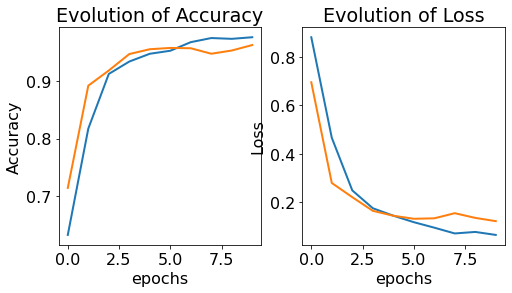

In [9]:
# Evaluate performances on the training set
mesures_perf_train = model.evaluate(x_train, y_train)
print('resultats train : ', mesures_perf_train)

# Evaluate performances on the test set
mesures_perf_test = model.evaluate(x_test, y_test)
print('resultats test : ', mesures_perf_test)

# Display performances through epochs
plt.figure(figsize=(8,4))
# Accuracy evolution
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Evolution of Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')

plt.subplot(1,2,2)
# Loss function evolution
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Evolution of Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')

In [10]:
model.save('CNN.h5')

# Checks

In [65]:
def getConfusionMatrix(true_labels, pred_labels, plot=False):
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    conf_matrix_norm = (conf_matrix.T / np.sum(conf_matrix, axis=1)).T

    if plot:
        opts = {'cmap' : 'RdBu_r'}

        plt.pcolor(conf_matrix_norm, **opts, norm=SymLogNorm(0.1))
        plt.yticks(np.arange(0.5, conf_matrix.shape[1], 1), range(3))
        plt.xticks(np.arange(0.5, conf_matrix.shape[0], 1), range(3))

        for irow in range(conf_matrix.shape[0]):           
            for icol in range(conf_matrix.shape[1]):                    
                plt.text(icol+0.5, irow+0.5, '{:.3f}'.format(conf_matrix_norm[irow][icol]),
                         ha="center", va="center", color="black") 

        plt.xlabel('Predicted class')
        plt.ylabel('True class')
        
    return conf_matrix_norm

In [11]:
predictions = model.predict(x_test)
pred_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

In [3]:
import keras.models
cnn = keras.models.load_model('CNN.h5')

predictions = cnn.predict(x_test)
pred_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

/home/theo/anaconda3/envs/keras-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  


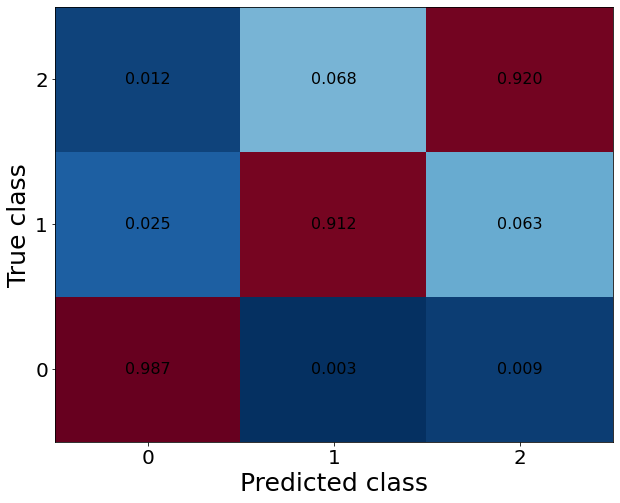

In [67]:
cm_nom = getConfusionMatrix(true_labels, pred_labels, plot=True)

In [68]:
x_test_lumi = np.mean( x_test.reshape((1786,240*320)), axis=1 )
mask = x_test_lumi < np.median(x_test_lumi)

In [69]:
cm_lumi_down = getConfusionMatrix(true_labels[mask], pred_labels[mask])

In [70]:
cm_lumi_up = getConfusionMatrix(true_labels[~mask], pred_labels[~mask])

## Export confusion matrices

In [73]:
conf_matrix_dict = {}
conf_matrix_dict['nominal'] = cm_nom.tolist()
conf_matrix_dict['lumi_down'] = cm_lumi_down.tolist()
conf_matrix_dict['lumi_up'] = cm_lumi_up.tolist()

with open('confusion_matrix.json', 'w') as f:
    json.dump(conf_matrix_dict, f, indent=4)

In [74]:
conf_matrix_dict

{'nominal': [[0.9872231686541738, 0.0034071550255536627, 0.009369676320272573],
  [0.024793388429752067, 0.9118457300275482, 0.06336088154269973],
  [0.012048192771084338, 0.06827309236947791, 0.9196787148594378]],
 'lumi_down': [[0.9902120717781403,
   0.0016313213703099511,
   0.008156606851549755],
  [0.023952095808383235, 0.9041916167664671, 0.0718562874251497],
  [0.008849557522123894, 0.07964601769911504, 0.911504424778761]],
 'lumi_up': [[0.983957219251337, 0.0053475935828877, 0.0106951871657754],
  [0.025510204081632654, 0.9183673469387755, 0.05612244897959184],
  [0.014705882352941176, 0.058823529411764705, 0.9264705882352942]]}

## Probablities distribution

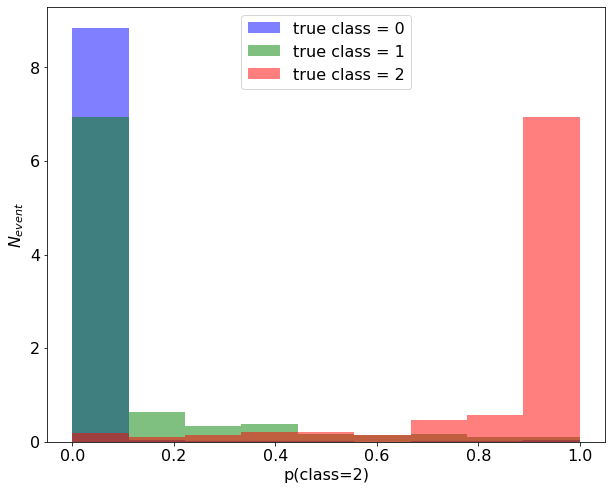

In [14]:
pred_class = 2

bins= np.linspace(0, 1, 10)
bins = np.append(bins,1)

plt.hist( predictions[:,pred_class][true_labels == 0], bins=bins, color='blue', label='true class = 0',
          density=True, alpha=0.5)
plt.hist( predictions[:,pred_class][true_labels == 1], bins=bins, color='green', label='true class = 1',
          density=True, alpha=0.5)
plt.hist( predictions[:,pred_class][true_labels == 2], bins=bins, color='red', label='true class = 2',
          density=True, alpha=0.5)

plt.xlabel(f'p(class={pred_class})')
plt.ylabel('$N_{event}$')
plt.legend()